In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import scipy.optimize as op

In [2]:
Temps = pd.read_hdf('calibration/Days14_15.hdf5')
log_Temps = np.log10(Temps)

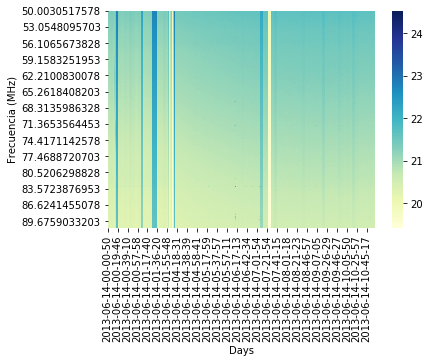

In [3]:
cols = Temps.columns.values
sb.heatmap(log_Temps[cols[0:2500]], cmap='YlGnBu', yticklabels=400)
plt.xlabel('Days')
plt.ylabel('Frecuencia (MHz)')
plt.savefig('Imagenes/Data_%s_%s.png'%(cols[0],cols[2500]))


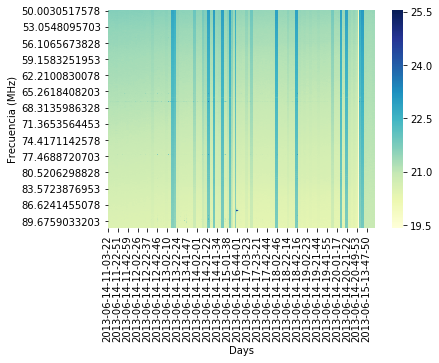

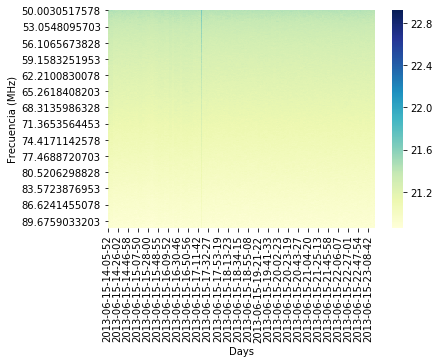

In [4]:
cols = Temps.columns.values
sb.heatmap(log_Temps[cols[2500:5000]], cmap='YlGnBu', yticklabels=400)
plt.xlabel('Days')
plt.ylabel('Frecuencia (MHz)')
plt.savefig('Imagenes/Data_%s_%s.png'%(cols[2500],cols[5000]))
plt.show()

sb.heatmap(log_Temps[cols[5000:]], cmap='YlGnBu', yticklabels=400)
plt.xlabel('Days')
plt.ylabel('Frecuencia (MHz)')
plt.savefig('Imagenes/Data_%s_%s.png'%(cols[5000],cols[-1]))
plt.show()

Text(33,0.5,u'Frecuencia (MHz)')

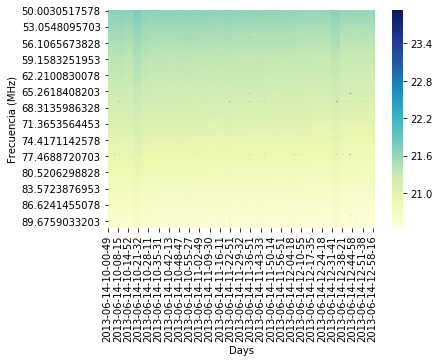

In [3]:
cols = Temps.columns.values
sb.heatmap(log_Temps.loc[:,'2013-06-14-10-00-49':'2013-06-14-13-00-30'], cmap='YlGnBu', yticklabels=400)
plt.xlabel('Days')
plt.ylabel('Frecuencia (MHz)')

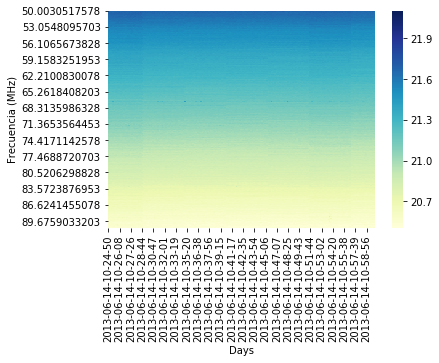

In [5]:
temp = Temps.loc[:,'2013-06-14-10-24-50':'2013-06-14-10-59-52']
data = temp.values
sb.heatmap(np.log10(temp), cmap='YlGnBu', yticklabels=400)
plt.xlabel('Days')
plt.ylabel('Frecuencia (MHz)')
plt.savefig('Imagenes/Data_%s_%s.png'%('2013-06-14-10-24-50','2013-06-14-10-59-52'))
index = Temps.index.values

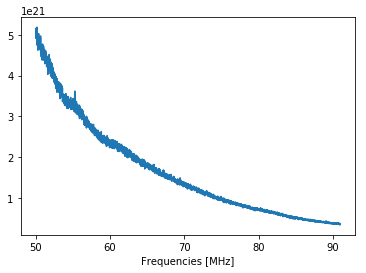

In [6]:
plt.plot(index,data[:,0])
plt.xlabel('Frequencies [MHz]')
plt.show()

In [7]:
data_gsm =  pd.read_hdf('calibration/Tgsm.hdf5')
data_reduce = data_gsm.loc[:,'2013-06-14 17:30:00.000':'2013-06-14 18:00:00.000']
T_gsm = data_reduce.values
freqs = data_reduce.index.values
np.shape(T_gsm)

data_reduce.head()

,2013-06-14 17:30:00.000,2013-06-14 17:35:00.000,2013-06-14 17:40:00.000,2013-06-14 17:45:00.000,2013-06-14 17:50:00.000,2013-06-14 17:55:00.000,2013-06-14 18:00:00.000
50,3629.098836,3620.980702,3614.871765,3610.298380,3607.281485,3605.825991,3606.246289
51,3460.993923,3453.224810,3447.370679,3442.979918,3440.077215,3438.662190,3439.038913
52,3303.561309,3296.119900,3290.503826,3286.284763,3283.489762,3282.112138,3282.447869
53,3155.946783,3148.812007,3143.419817,3139.361535,3136.667475,3135.325355,3135.623225
54,3017.377501,3010.531287,3005.349310,3001.442482,2998.843262,2997.534655,2997.796816


In [8]:
# Data binnig
freq_bins = []
for f in freqs:
    mask = (index>=f)&(index<f+1)
    freq_bins.append(np.mean(temp[mask]))
Temp_binfreq = np.array(freq_bins)

bins = int(np.shape(Temp_binfreq)[1]/25. +1) # Data binning in time, 25 is because every 25 data is 5 mins (Aprox 12 secs between data)
T_meas = np.zeros(np.shape(T_gsm))
T_std = np.zeros(np.shape(T_gsm))
for i in range(bins):
    T_meas[:,i] = np.mean(Temp_binfreq[:,i:i+25], axis =1)
    T_std[:,i] = np.std(Temp_binfreq[:,i:i+25], axis =1)

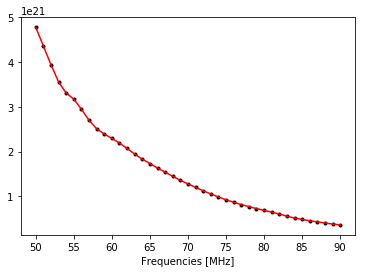

In [9]:
plt.plot(freqs,np.mean(T_meas,axis=1), '.k')
plt.plot(freqs,np.mean(T_meas,axis=1),'r')
plt.xlabel('Frequencies [MHz]')
plt.savefig('Uncalibrated.png')

In [10]:
def Chisq(k,Tmeas,Tgsm, error):
    #Chi = (logk + np.log10(Tmeas) - np.log10(Tgsm))**2
    Chi = (Tgsm- k*Tmeas/1.e19)**2./(error/1.e19)**2.
    return sum(Chi)

fun = lambda *args: Chisq(*args)

In [17]:
K = np.zeros(len(freqs))
for i in range(len(freqs)):
    K[i] = op.minimize(fun,1,args=(T_meas[i,:],T_gsm[i,:],T_std[i,:])).x[0] 

In [18]:
K

array([  7.5686155 ,   7.91928648,   8.35451961,   8.84632949,
         9.08548078,   9.0667677 ,   9.34768274,   9.77191481,
        10.07816894,  10.14508697,  10.15577015,  10.22425849,
        10.39352637,  10.64465049,  10.88698813,  11.06696364,
        11.32427221,  11.5659084 ,  11.87975062,  12.20098175,
        12.52619403,  12.88610611,  13.30220719,  13.70904583,
        14.17229764,  14.65038236,  15.09648868,  15.52985648,
        15.94986432,  16.38851418,  16.81279455,  17.28289912,
        17.96922204,  18.93608956,  19.90501637,  20.52407421,
        21.25339254,  21.86108844,  22.58011106,  23.28955419,  23.88675304])

In [19]:
K_nu = K*1e-19

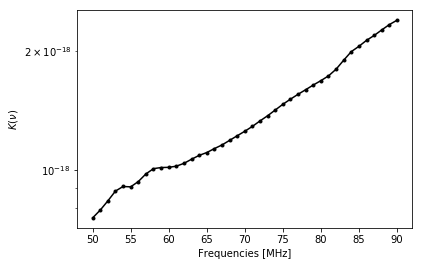

In [20]:
plt.semilogy(freqs,K_nu,'.-k')
plt.xlabel('Frequencies [MHz]')
plt.ylabel(r'$K(\nu)$')
plt.savefig('K_nu.png')

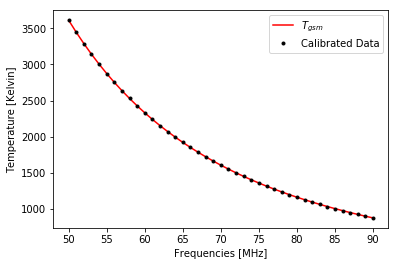

In [21]:
Tgsm_mean = np.mean(T_gsm,axis=1)
Tmeas_mean = np.mean(T_meas,axis=1)

plt.plot(freqs,Tgsm_mean, 'r',label=r'$T_{gsm}$')
plt.plot(freqs,K_nu*Tmeas_mean,'.k', label = 'Calibrated Data')
plt.xlabel('Frequencies [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()
plt.savefig('calibrated.png')

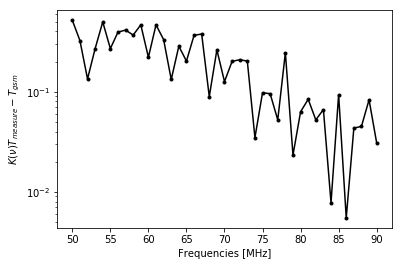

In [22]:
plt.semilogy(freqs,abs(K_nu*Tmeas_mean - Tgsm_mean),'.-k')
plt.xlabel('Frequencies [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')
plt.savefig('KTmeas-Tgsm.png')

In [61]:
for i in range(len(freqs)):
    K = op.minimize(fun,1,args=(T_meas[10,:],T_gsm[10,:],1)).x[0] 

In [66]:
K = K*1e-19

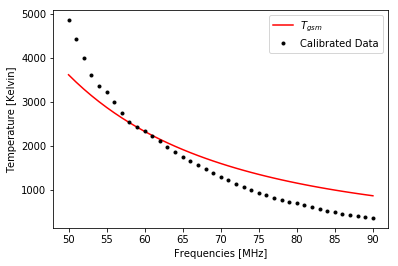

In [67]:
plt.plot(freqs,Tgsm_mean, 'r',label=r'$T_{gsm}$')
plt.plot(freqs,K*Tmeas_mean,'.k', label = 'Calibrated Data')
plt.xlabel('Frequencies [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()

Text(0,0.5,u'$K(\\nu)T_{measure}-T_{gsm}$')

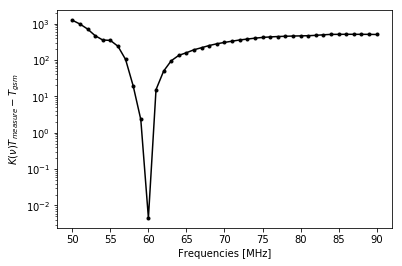

In [68]:
plt.semilogy(freqs,abs(K*Tmeas_mean - Tgsm_mean),'.-k')
plt.xlabel('Frequencies [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')